In [1]:
%%writefile Ind_RENKO_TRE.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd
import math

import QUANTAXIS as QA


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import patches

import numba as nb
import talib
import scipy.optimize as opt

import Analysis_Funs as af

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class RENKO(Ind_Model_Base.Ind_Model):
    optimum_param={'valid':True, 'main':'feature_RENKO_JXSX', 'desition_direct':1, 'freq':'d','neutralize':{'enable':True,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY, sensitive_mode=False):
        super().__init__(data, 'RENKO', frequence)
        self.sensitive_mode = sensitive_mode
        self.renko_objs={}
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':14}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        JXSX = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(af.feature_JXSX_timeline(x['direct']),
                                         index=x.index,
                                         columns=['feature_RENKO_JXSX']))
        continuity = self.excute_for_multicode(self.ind_df, 
                                               lambda x: pd.DataFrame(af.timeline_event_continuity(x['direct'].values),
                                               index=x.index,
                                               columns=['feature_RENKO_CONTINUITY']))
#         continuity['feature_RENKO_CONTINUITY_ABS'] = np.abs(continuity['feature_RENKO_CONTINUITY'])
        
        self.ind_df = pd.concat([self.ind_df, JXSX, continuity],axis=1)
        return None #pd.concat([JXSX,continuity],axis=1)
        
    def kernel(self,dataframe,timeperiod=14):
        hlc = dataframe[['high','low','close']]
        if len(hlc)<2:
            return None
        
        optimal_brick = get_optimal_brick_ML(hlc, self.cur_pramas['timeperiod'])
        if optimal_brick is None:
            return None
        
        if self.sensitive_mode:
            renko_objc = renko_chart_sensitive(hlc.close.values, optimal_brick,condensed=True)
            ret_indices = pd.DataFrame(renko_objc[:,0:3], 
                                       columns=['low_band', 'upper_band', 'direct'], 
                                       index=hlc.index)
        else:
            renko_objc = renko_chart()
            renko_objc.set_brick_size(brick_size = optimal_brick, auto = False)
            renko_objc.build_history(prices = hlc.close.values)
            # up时，boundary为上边界，down时，boundary为下边界
            ret_indices = pd.DataFrame(renko_objc.source_aligned, 
                                       columns=['boundary', 'initial', 'direct'], 
                                       index=hlc.index)
            
        if not self.fast_mode:
            self.renko_objs[dataframe.index.get_level_values(1)[0]] = renko_objc
        
        
        
        if self.fast_mode:
            return ret_indices.iloc[:,2:3]


        return ret_indices

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        if self.sensitive_mode:
            for i in self.renko_objs.keys():
                plot_renko_chart(self.renko_objs[i],i)
        else:
            for i in self.renko_objs.keys():
                self.renko_objs[i].plot_renko(chart_name=i)
        




Writing Ind_RENKO_TRE.py


In [41]:
%%writefile -a Ind_RENKO.py

class renko_chart:
    """
    Renko Chart/Renko Brick/Renko Bar
    A renko chart is a type of financial chart of Japanese origin used in 
    technical analysis that measures and plots price changes.
    Renko砖块图是一种由日本人发明的用于衡量和绘制价格变化的财务技術分析图表。Renko图由砖块
    组成，与典型的蜡烛图相比，它可以通过剔除噪音的方式，帮助投资者更好的分析趋势和进行量化研究，
    更清晰地显示市场趋势并提高信噪比。
    """
    def __init__(self, hlc=None):
        """
        Inti data, 
        params
        ---------
        hlc:ndarray | optial, with hlc/ohlc price data

        初始化数据
        可选参数---
        hlc: ndarray | optial, 包含 3/4 列 hlc/ohlc 价格信息
        """
        self.source_prices = []
        self.renko_prices = []
        self.renko_directions = []

        self.source_aligned = []
        self.renko_gaps = []

        # 增加上下影线
        # For upper lower shadow
        self.renko_upper_shadow = []
        self.renko_lower_shadow = []
        

        if ((hlc is not None) and (len(hlc) > 0)):
            if (len(hlc[0, :]) == 3):
                self.source_hlc = hlc
            elif (len(hlc[0, :]) >= 4):
                self.source_hlc = hlc[:, [1, 2, 3]]
            else:
                print(u'renko(hlc) must has 3~4 columns data with high, low, close price.')
                self.source_hlc = []
        else:
            self.source_hlc = []
        
    def set_brick_size(self, HLC_history=None, auto=True, brick_size=10.0):
        """
        Setting brick size.  Auto mode is preferred, it uses history
        """
        if (isinstance(HLC_history, np.ndarray)):
            HLC_history = HLC_history[:, [0, 1, 2]]
        elif (isinstance(HLC_history, pd.DataFrame)):
            HLC_history = HLC_history.iloc[:, [0, 1, 2]].values

        if auto == True:
            self.brick_size = self.__get_optimal_brick_size(HLC_history)
        else:
            self.brick_size = brick_size
        return self.brick_size
    
    def __renko_rule(self, last_price, aligned_idx=0):
        """
        Renko brick increasing rule
        """
        # Get the gap between two prices
        gap_div = int(float(last_price - self.renko_prices[-1]) / self.brick_size)
        is_new_brick = False
        start_brick = 0
        num_new_bars = 0

        # When we have some gap in prices
        if gap_div != 0:
            # Forward any direction (up or down)
            if (gap_div > 0 and (self.renko_directions[-1] > 0 or self.renko_directions[-1] == 0)) or (gap_div < 0 and (self.renko_directions[-1] < 0 or self.renko_directions[-1] == 0)):
                num_new_bars = gap_div
                is_new_brick = True
                start_brick = 0
            # Backward direction (up -> down or down -> up)
            elif np.abs(gap_div) >= 2: # Should be double gap at least
                num_new_bars = gap_div
                num_new_bars -= np.sign(gap_div)
                start_brick = 2
                is_new_brick = True

                next_price = self.renko_prices[-1] + 2 * self.brick_size * np.sign(gap_div)
                self.renko_prices.append(next_price)
                self.renko_directions.append(np.sign(gap_div))

                # 记录上下影线
                if (len(self.source_hlc) > 0):
                    self.renko_upper_shadow.append(self.source_hlc[aligned_idx, 0])
                    self.renko_lower_shadow.append(self.source_hlc[aligned_idx, 1])
                self.renko_gaps.append(aligned_idx)
            #else:
                #num_new_bars = 0

            if is_new_brick:
                # Add each brick
                for d in range(start_brick, np.abs(gap_div)):
                    next_price = self.renko_prices[-1] + self.brick_size * np.sign(gap_div)
                    self.renko_prices.append(next_price)
                    self.renko_directions.append(np.sign(gap_div))

                    # 记录上下影线
                    if (len(self.source_hlc) > 0):
                        self.renko_upper_shadow.append(self.source_hlc[aligned_idx, 0])
                        self.renko_lower_shadow.append(self.source_hlc[aligned_idx, 1])
                    self.renko_gaps.append(aligned_idx)

        return num_new_bars
    
    def build_history(self, prices=None, hlc=None):
        """
        Getting renko on history
        生成 Renko brick 序列（非时间顺序，按时间顺序的 Renko 序列在）
        """
        if ((hlc is not None) and (len(hlc) > 0)):
            if (len(hlc[0, :]) == 3):
                prices = hlc[:, 2]
                self.source_hlc = hlc
            elif (len(hlc[0, :]) >= 4):
                prices = hlc[:, 3]
                self.source_hlc = hlc[:, [1, 2, 3]]
            else:
                print(u'renko.build_history(hlc) must has 3~4 columns data with high, low, close price.')

        if len(prices) > 0:
            # Init by start values
            self.source_prices = prices
            self.renko_prices.append(prices[0])
            self.renko_directions.append(0)

            # 记录上下影线
            if (len(self.source_hlc) > 0):
                self.renko_upper_shadow.append(self.source_hlc[0, 0])
                self.renko_lower_shadow.append(self.source_hlc[0, 1])

            self.source_aligned = np.zeros((len(prices),3))
        
            # For each price in history
            idx = 1
            for p in self.source_prices[1:]:
                ret_new = self.__renko_rule(p, idx)

                # 同步Renko线到真实K线时间
                # Align Renko Price to real ohlc‘s xlim
                if (len(self.renko_prices) <= 1) or \
                    ((len(self.renko_prices) > 1) and (abs(self.renko_prices[-1] - self.renko_prices[-2]) == self.brick_size)):
                    self.source_aligned[idx, 0] = self.renko_prices[-1] - self.brick_size if self.renko_directions[-1] == 1 else self.renko_prices[-1]
                    self.source_aligned[idx, 1] = self.renko_prices[-1] if self.renko_directions[-1] == 1 else self.renko_prices[-1] - self.brick_size
                else:
                    # 跳空
                    self.source_aligned[idx, 0] = self.renko_prices[-1] + self.brick_size if self.renko_directions[-1] == 1 else self.renko_prices[-1]
                    self.source_aligned[idx, 1] = self.renko_prices[-1] if self.renko_directions[-1] == 1 else self.renko_prices[-1] + self.brick_size
                self.source_aligned[idx, 2] = self.renko_directions[-1]

                # 记录上下影线
                if (len(self.source_hlc) > 0):
                    self.renko_upper_shadow[-1] = self.renko_upper_shadow[-1] if (self.renko_upper_shadow[-1] > self.source_hlc[idx, 0]) else self.source_hlc[idx, 0]
                    self.renko_lower_shadow[-1] = self.renko_lower_shadow[-1] if (self.renko_lower_shadow[-1] < self.source_hlc[idx, 1]) else self.source_hlc[idx, 1]

                idx = idx + 1

        return len(self.renko_prices)
    
    # Getting next renko value for last price
    def do_next(self, last_price):
        if len(self.renko_prices) == 0:
            self.source_prices.append(last_price)
            self.renko_prices.append(last_price)
            self.renko_directions.append(0)
            return 1
        else:
            self.source_prices.append(last_price)
            return self.__renko_rule(last_price)
    
    # Simple method to get optimal brick size based on ATR
    def __get_optimal_brick_size(self, HLC_history, atr_timeperiod=14):
        brick_size = 0.0
        
        # If we have enough of data
        if HLC_history.shape[0] > atr_timeperiod:
            brick_size = np.median(talib.ATR(high = np.double(HLC_history[:, 0]), 
                                             low = np.double(HLC_history[:, 1]), 
                                             close = np.double(HLC_history[:, 2]), 
                                             timeperiod = atr_timeperiod)[atr_timeperiod:])
        
        return brick_size

    def evaluate(self, method='simple'):
        balance = 0
        sign_changes = 0
        price_ratio = len(self.source_prices) / len(self.renko_prices)

        if method == 'simple':
            for i in range(2, len(self.renko_directions)):
                if self.renko_directions[i] == self.renko_directions[i - 1]:
                    balance = balance + 1
                else:
                    balance = balance - 2
                    sign_changes = sign_changes + 1

            if sign_changes == 0:
                sign_changes = 1

            score = balance / sign_changes
            if score >= 0 and price_ratio >= 1:
                score = np.log(score + 1) * np.log(price_ratio)
            else:
                score = -1.0

            return {'balance': balance, 'sign_changes:': sign_changes, 
                    'price_ratio': price_ratio, 'score': score}
    
    def get_renko_prices(self):
        """
        返回每个 Renko bar 的价格
        """
        return self.renko_prices
    
    def get_renko_directions(self):
        """
        返回每个 Renko bar 的方向
        """
        return self.renko_directions

    def get_renko_upper_shadow(self):
        """
        返回每个 Renko bar 的上影线
        """
        return self.renko_upper_shadow

    def get_renko_lower_shadow(self):
        """
        返回每个 Renko bar 的下影线
        """
        return self.renko_lower_shadow

    def get_renko_gaps(self):
        """
        返回每个 Renko bar 的原始时间轴坐标起点
        """
        return self.renko_gaps
    
    def get_source_aligned(self):
        """
        返回时间轴对齐原始 OHLC 的 Renko Bars
        """
        return self.source_aligned
 
    def plot_renko(self, ohlc=None, chart_name=None, col_up='r', col_down='g'):
        """
        没事画个图
        """
        fig, ax = plt.subplots(1, figsize=(20, 10))
        if chart_name is None:
            ax.set_title('Renko chart')
        else:
            ax.set_title(chart_name)
        ax.set_xlabel('Renko bars')
        ax.set_ylabel('Price')

        if (ohlc is not None):
            #ax_ohlc = ax.twinx()
            mpf.candlestick2_ochl(ax,
                                  ohlc.open,
                                  ohlc.close,
                                  ohlc.high,
                                  ohlc.low,
                                  width=0.6, colorup='r', colordown='green',
                                  alpha=0.5)

            # Set datetime as y-label for MultiIndex
            DATETIME_LABEL = ohlc.index.get_level_values(level=0).to_series().apply(lambda x: x.strftime("%Y-%m-%d %H:%M")[2:16])
            # Set datetime as y-label for DatetimIndex
            #DATETIME_LABEL = ohlc.index.to_series().apply(lambda x:
            #x.strftime("%Y-%m-%d %H:%M")[2:16])
            ax.set_xticks(range(0, len(DATETIME_LABEL), round(len(ohlc) / 16)))
            ax.set_xticklabels(DATETIME_LABEL[::round(len(ohlc) / 16)], rotation = 10)
            ax.grid(True)

            ax.plot(DATETIME_LABEL, 
                    self.source_aligned[:, 0] , 
                    lw=0.75, 
                    color='cyan', 
                    alpha=0.6)
            ax.plot(DATETIME_LABEL, 
                    self.source_aligned[:, 1] ,
                    lw=0.75, 
                    color='fuchsia', 
                    alpha=0.6)
            ax.fill_between(DATETIME_LABEL, 
                             np.where(self.source_aligned[:, 2] == 1, 
                                      self.source_aligned[:, 0], 
                                      np.nan), 
                             np.where(self.source_aligned[:, 2] == 1, 
                                      self.source_aligned[:, 1], 
                                      np.nan), 
                             color='lightcoral', alpha=0.15)
            ax.fill_between(DATETIME_LABEL, 
                             np.where(self.source_aligned[:, 2] == -1, 
                                      self.source_aligned[:, 0], 
                                      np.nan), 
                             np.where(self.source_aligned[:, 2] == -1, 
                                      self.source_aligned[:, 1], 
                                      np.nan), 
                             color='limegreen', alpha=0.15)
        else:
            # Calculate the limits of axes
            ax.set_xlim(0.0,
                        len(self.renko_prices) + 1.0)
            ax.set_ylim(np.min(self.renko_prices) - 3.0 * self.brick_size,
                        np.max(self.renko_prices) + 3.0 * self.brick_size)
        
            # Plot each renko bar
            for i in range(1, len(self.renko_prices)):
                # Set basic params for patch rectangle
                col = col_up if self.renko_directions[i] == 1 else col_down
                x = i
                y = self.renko_prices[i] - self.brick_size if self.renko_directions[i] == 1 else self.renko_prices[i]
                height = self.brick_size
                
                # Draw bar with params
                ax.add_patch(patches.Rectangle((x, y), # (x,y)
                        1.0, # width
                        self.brick_size, # height
                        facecolor = col))

def get_optimal_brick_ML(hlc_df, timeperiod = 14):
    
    if len(hlc_df) <= timeperiod:
        return None
    
    atr = talib.ATR(high = np.double(hlc_df.high),
                    low = np.double(hlc_df.low),
                    close = np.double(hlc_df.close),
                    timeperiod = timeperiod)

    atr = atr[np.isnan(atr) == False]

    def evaluate_renko(brick, history, column_name):
        renko_obj = renko_chart()
        renko_obj.set_brick_size(brick_size = brick, auto = False)
        renko_obj.build_history(prices = history)
        return renko_obj.evaluate()[column_name]

    try:
        optimal_brick_sfo = opt.fminbound(lambda x: -evaluate_renko(brick = x, 
                                          history = hlc_df.close, 
                                          column_name = 'score'), np.min(atr), np.max(atr), disp=0)
    except Exception as e:
        print("atr:",atr)
        print("hlc_df:",hlc_df)
        print(e)
        raise 'get_optimal_brick_MLerrorrrrrr'
        
            
    return optimal_brick_sfo

Appending to Ind_RENKO.py


In [42]:
%%writefile -a Ind_RENKO.py

@nb.jit(nopython=True)
def renko_chart_sensitive(price_series, N, condensed=True):
    """
    原版代码来自QUANTAXIS QA.RENKO，经过numba jit优化，最终输出格式统一为
    2维数组，4列数据：Lower Band/Upper Band/Direction/price
    灵敏度更高的版本。
    """
    idx_renko_price = 3
    idx_renko_direction = 2
    idx_renko_lb = 0
    idx_renko_ub = 1
    ret_renko_chart = np.zeros((len(price_series), 4,))

    last_price = price_series[0]
    chart = [last_price]
    for i in range(0, len(price_series)):
        price = price_series[i]
        bricks = math.floor(abs(price - last_price) / N)
        if bricks == 0:
            if condensed:
                ret_renko_chart[i, idx_renko_price] = chart[-1]
                chart.append(chart[-1])
            continue
        sign = int(np.sign(price - last_price))
        #print(price_series[i-1], price_series[i], [sign * (last_price + (sign
        #* N * x)) for x in range(1, bricks + 1)])
        chart += [sign * (last_price + (sign * N * x)) for x in range(1, bricks + 1)]
        ret_renko_chart[i, idx_renko_price] = chart[-1]
        last_price = abs(chart[-1])

    ret_renko_chart[:, idx_renko_direction] = np.sign(ret_renko_chart[:, idx_renko_price])
    ret_renko_chart[:, idx_renko_lb] = np.where(ret_renko_chart[:, idx_renko_direction] < 0,
                                                -ret_renko_chart[:, idx_renko_price] - N,
                                                ret_renko_chart[:, idx_renko_price])
    ret_renko_chart[:, idx_renko_ub] = np.where(ret_renko_chart[:, idx_renko_direction] > 0,
                                                ret_renko_chart[:, idx_renko_price] + N,
                                                -ret_renko_chart[:, idx_renko_price])

    return ret_renko_chart


def plot_renko_chart(bricks, chart_name=None):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    if chart_name is None:
        ax.set_title('Renko chart')
    else:
        ax.set_title(chart_name)
            
    ax.set_xlim(0.0,len(bricks) + 1.0)
    ax.set_ylim(np.min(bricks[:,1])- 3.0 , np.max(bricks[:,1])+ 3.0)
    
    for idx, brick in enumerate(bricks):
        facecolor = 'red' if brick[2] > 0 else 'green'
#         print(idx, min(brick[2],brick[3]),abs(brick[3]-brick[2]),facecolor)
        if brick[2] > 0:
            y = min(brick[0],brick[1])
        else:
            y = max(brick[0],brick[1])
        rect = patches.Rectangle(
                            (idx, y), 
                             1, abs(brick[1]-brick[0]),
                             facecolor=facecolor)
        ax.add_patch(rect)
        


Appending to Ind_RENKO.py


In [206]:
import tools.Sample_Tools as smpl
data = smpl.get_data(['000001','000002'],start='2010-01-15',gap=66).data
ind_obj = RENKO(data,sensitive_mode=True) 
ind_obj.set_fast_mode(True)
%time ind_obj.fit()
# ind_obj.ind_df.loc(axis=0)[pd.IndexSlice[:, '000001']]
# pd.DataFrame(ind_obj.ind_df.loc[(slice(None),'000001'),:].values.T[0],index=data.loc[(slice(None),'000001'),:].index,columns=['feature_RENKO_JXSX'])
ind_obj.ind_df

Wall time: 38 ms


direct  feature_RENKO_JXSX  feature_RENKO_CONTINUITY
date       code                                                        
2010-01-15 000001     1.0                  -1                         1
           000002     1.0                  -1                         1
2010-01-18 000001     1.0                  -2                         2
           000002     1.0                  -2                         2
2010-01-19 000001     1.0                  -3                         3
...                   ...                 ...                       ...
2010-04-23 000002    -1.0                 -13                       -13
2010-04-26 000001    -1.0                 -11                       -11
           000002    -1.0                 -14                       -14
2010-04-27 000001    -1.0                 -12                       -12
           000002    -1.0                 -15                       -15

[132 rows x 3 columns]

In [24]:
# ind_obj.plot()
af.feature_JXSX_timeline(ind_obj.ind_df.loc[(slice(None),'000001'),:])


NameError: name 'af' is not defined

In [151]:
af.timeline_event_continuity(ind_obj.ind_df.loc[(slice(None),'000001'),:].values.T[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  -1,  -2,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11,
       -12])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:32704  pid:6916


  0%|          | 0/4 [00:00<?, ?it/s]

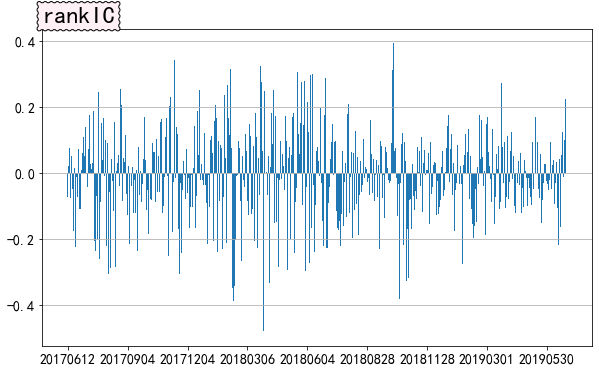

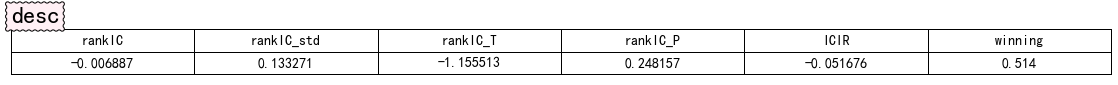

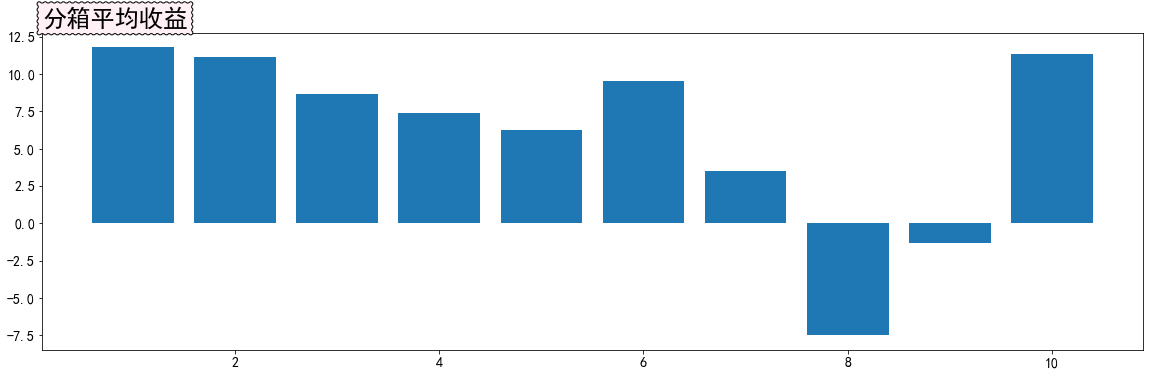

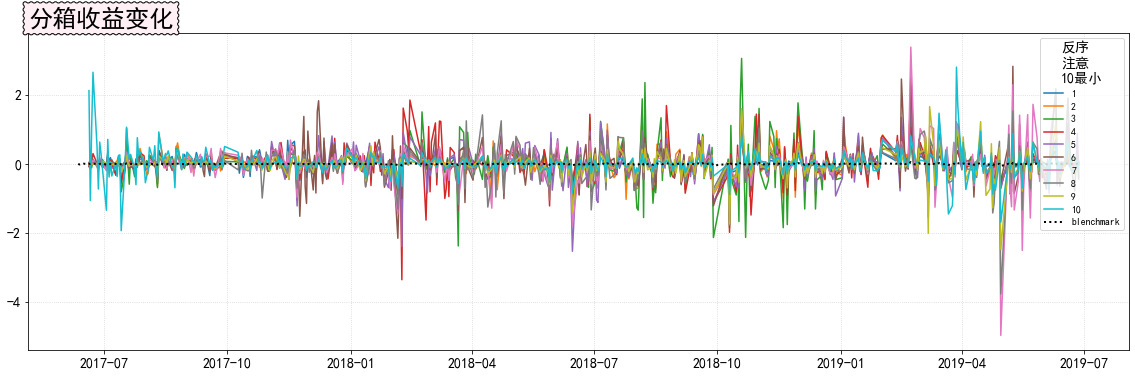

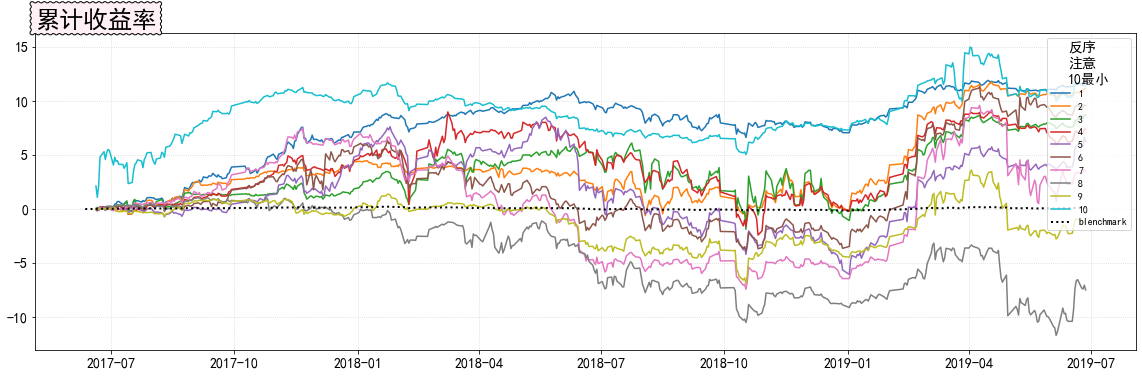

Wall time: 24.9 s


In [7]:
%%time

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
from tools.Test_Tools import FactorTest

from ind.Ind_RENKO import RENKO as RENKO_X

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,ind.Ind_RENKO

# sample='沪深300'

test = FactorTest(RENKO_X, sample='沪深300', freq="d",end='2019-06-29',gap=500,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='feature_RENKO_JXSX')
# test.process()
test.process_multi()
test.plot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:6152  pid:52684


  0%|          | 0/4 [00:00<?, ?it/s]

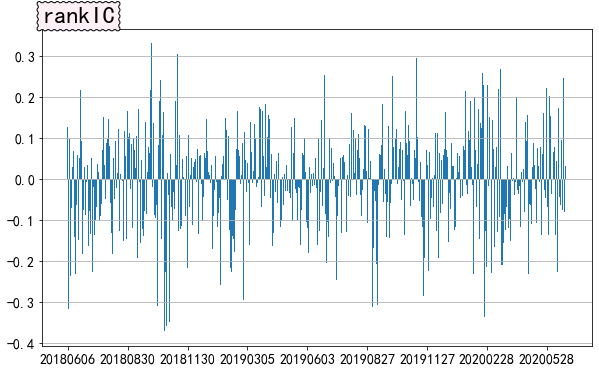

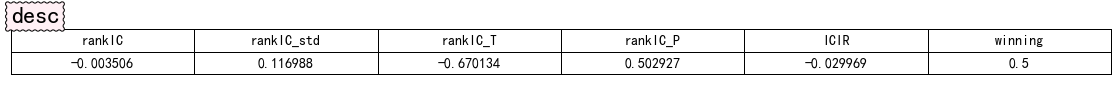

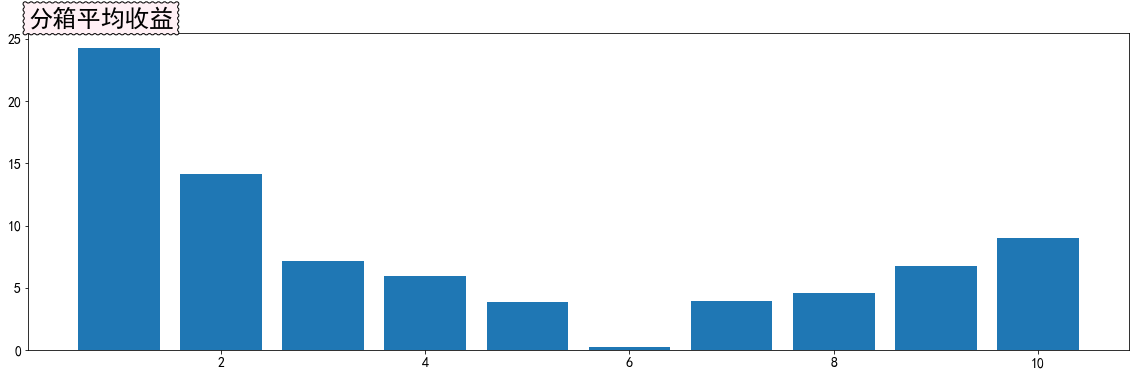

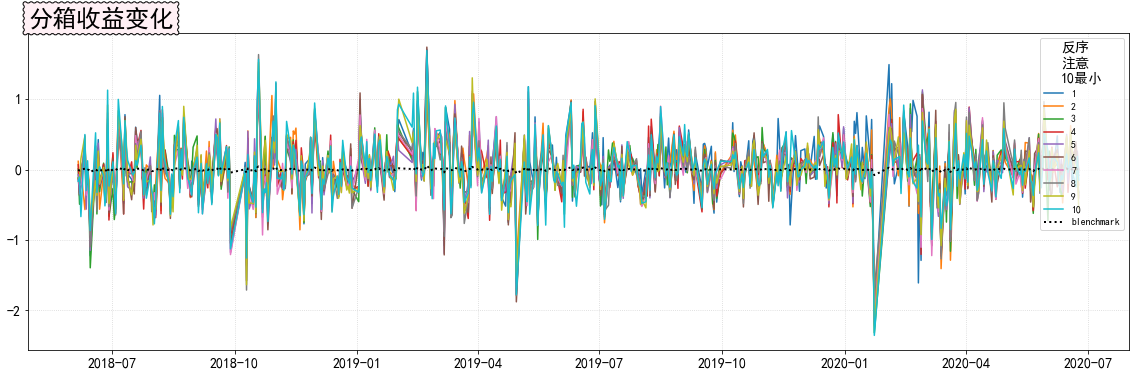

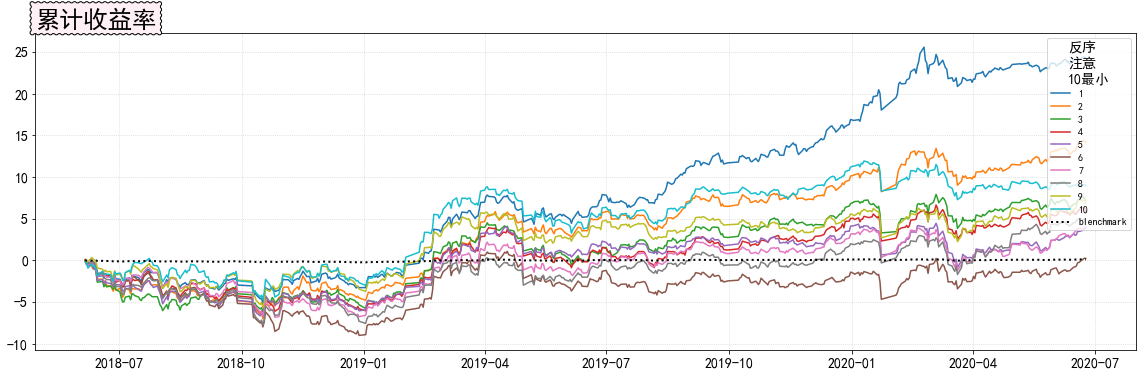

In [14]:
from tools.Test_Tools import FactorTest

from ind.Ind_RENKO import RENKO as RENKO_X

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,ind.Ind_RENKO

test = FactorTest(RENKO_X, sample='沪深300', freq="d",end='2020-06-29',gap=500,only_main=True,neutralize={'enable':True,'static_mv':False},target_field='feature_RENKO_JXSX')
# test.process()
test.process_multi()
test.plot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


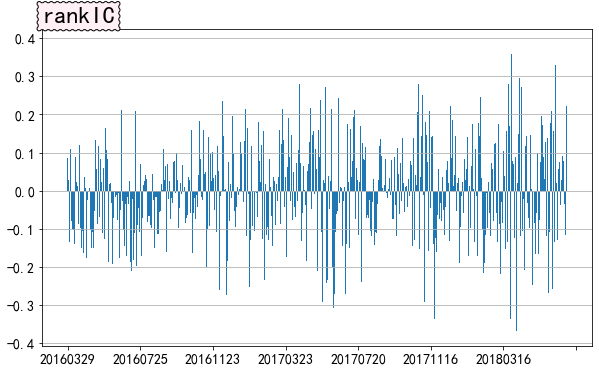

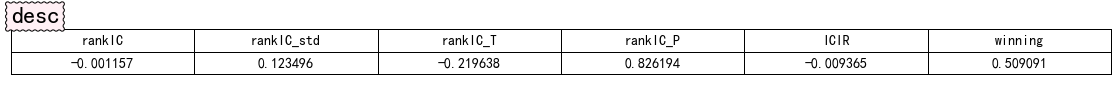

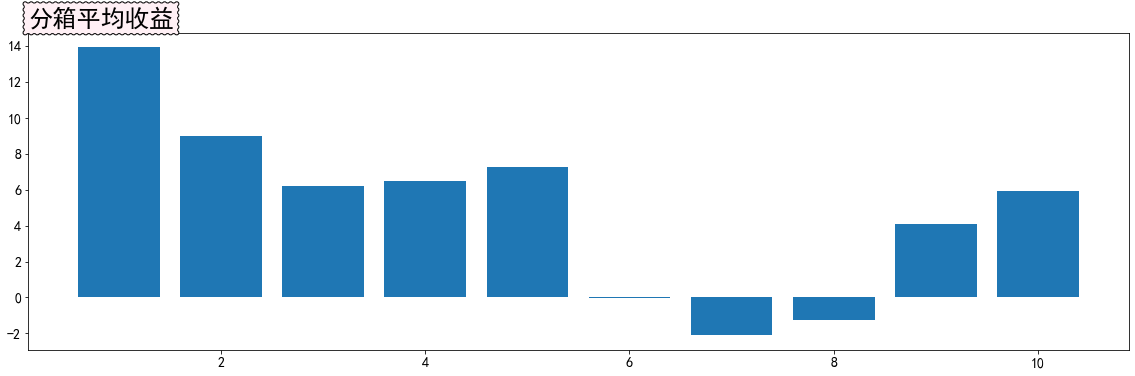

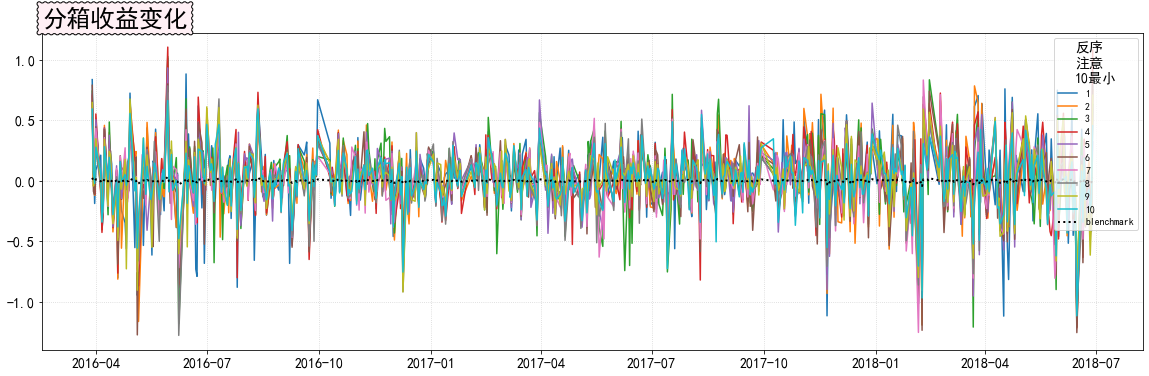

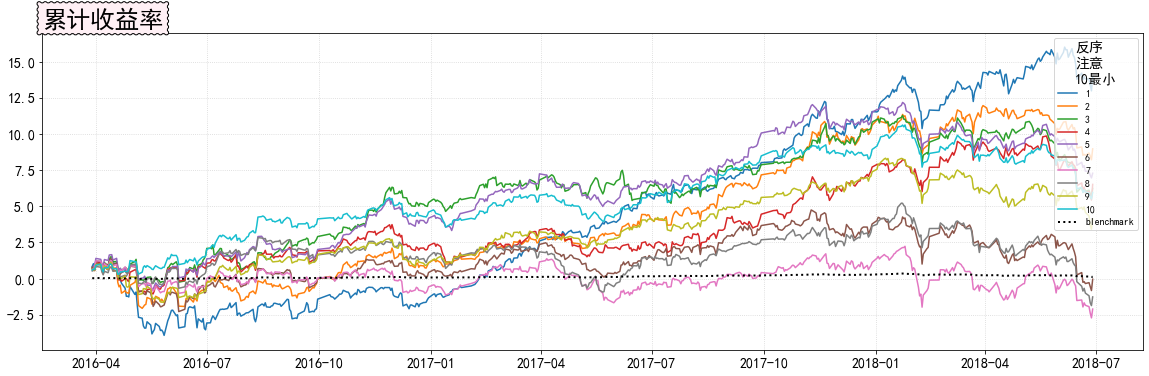

In [12]:
# import sys
# import os 
# module_path = os.path.abspath(os.path.join('..')) 
# if module_path not in sys.path: 
#     sys.path.append(module_path)

from tools.Test_Tools import FactorTest

from ind.Ind_RENKO import RENKO as RENKO_X

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,ind.Ind_RENKO

test = FactorTest(RENKO_X, sample='沪深300', freq="d",end='2018-06-29',gap=550,only_main=True,neutralize={'enable':True,'static_mv':False},target_field='feature_RENKO_JXSX')
test.process_multi()
test.plot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:6152  pid:52684


  0%|          | 0/4 [00:00<?, ?it/s]

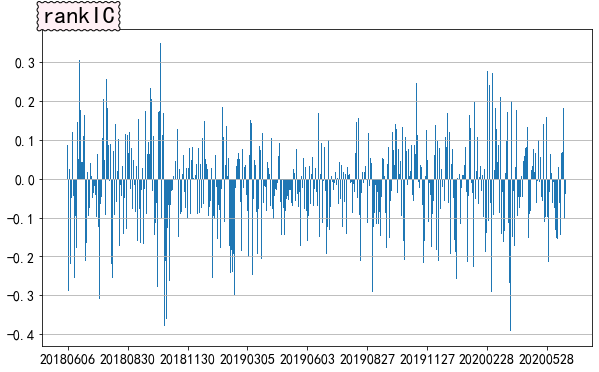

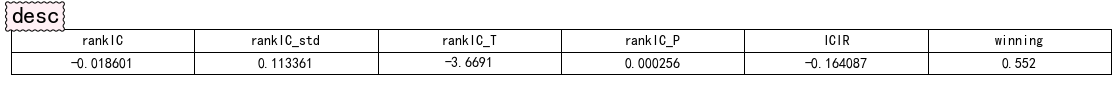

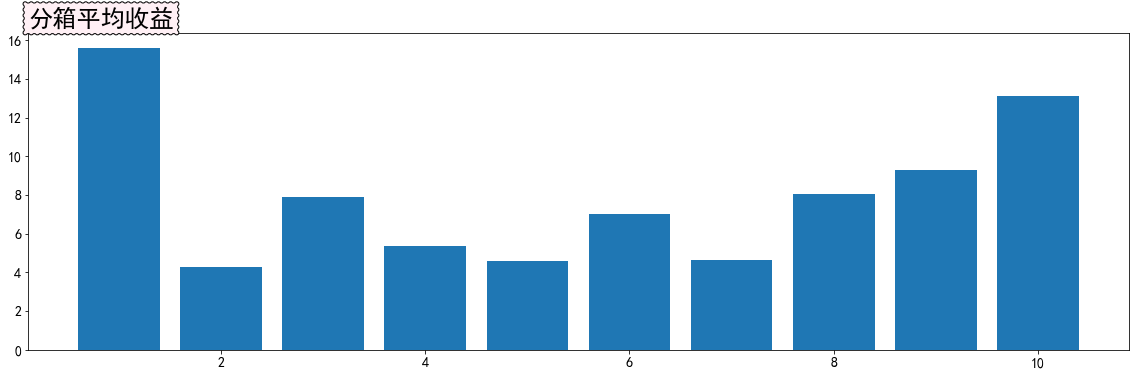

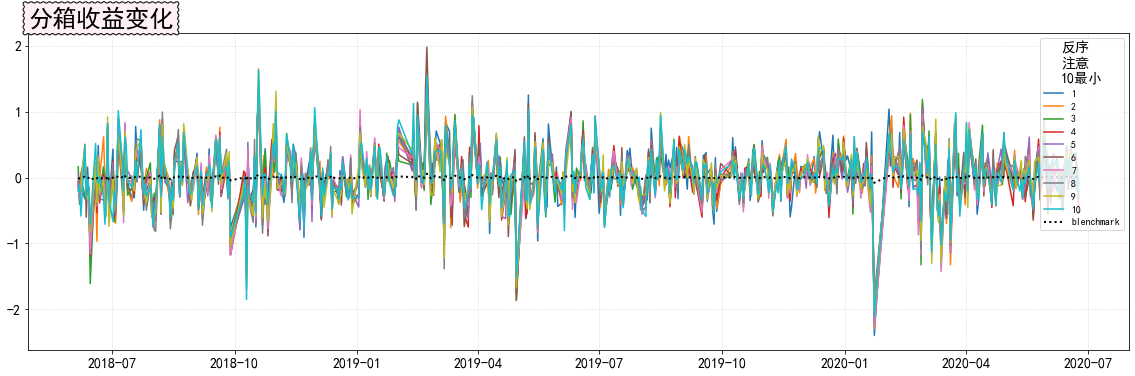

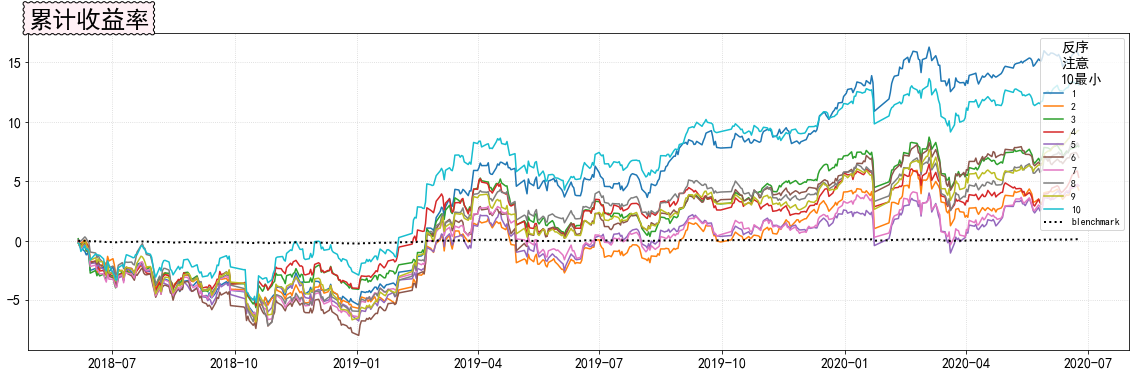

In [39]:
##sensitive_mode=True

from ind.Ind_RENKO import RENKO as RENKO_X

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,ind.Ind_RENKO

test = FactorTest(RENKO_X, sample='沪深300', freq="d",end='2018-06-29',gap=500,only_main=True,neutralize={'enable':True,'static_mv':False},target_field='feature_RENKO_JXSX')
# test.process()
test.process_multi()
test.plot()